# Comprehensive Robustness Analysis: Single + Stacked Scenarios
Combine single degradation tests with realistic stacked scenario tests. Compare accuracy across all test types and visualize robustness summary.

In [ ]:
import os
import time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import cv2
import joblib

## Import required libraries
Set up imports for data handling, visualization, model loading, and reproducibility with fixed random seeds.

## Import required libraries
Set up imports for data handling, visualization, model loading, and reproducibility with fixed random seeds.

In [ ]:
ROOT_DIR = "dataset/fruit360"
TEST_DIR = os.path.join(ROOT_DIR, "Test")
CKPT_ROOT = Path("artifacts/checkpoints")

SIZE = 32
COLOR_BINS = 16

class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            label = class_name if self.variety else class_name.split()[0]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.png')):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for i, lbl in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label_str

transform_32 = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

test_dataset_32 = Fruit360FolderDataset(TEST_DIR, transform=transform_32, variety=False)

BATCH_SIZE = 100
test_loader_32 = DataLoader(test_dataset_32, batch_size=BATCH_SIZE, shuffle=False)
print(f"Test loader 32x32: {len(test_dataset_32)} images, {len(test_loader_32)} batches")

Test: 43442 images, 79 classes
Test loader 32x32: 43442 images, 435 batches


## Load test dataset and create DataLoader
Create test dataset from folder structure with `SIZE=32`, `COLOR_BINS=16`. Use `variety=False` for coarse fruit labels. Batch images for efficient feature extraction.

**Change here:** `SIZE`, `BATCH_SIZE`, `variety` to adjust image resolution, batch processing, and label granularity.

In [ ]:
import math

def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)

def dark_mild(x):
    return clamp_01(x * 0.65)

def overexposed_mild(x):
    return clamp_01(x * 1.35)

def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)

blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)

def scenario_A(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x

def scenario_B(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x

def scenario_C(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x

scenario_fns = {
    "scenario_A": scenario_A,
    "scenario_B": scenario_B,
    "scenario_C": scenario_C,
}
print(list(scenario_fns.keys()))

['scenario_A', 'scenario_B', 'scenario_C']


## Define degradation and scenario functions
Implement individual degradations (noise, blur, lighting, dirt, bruising, occlusion) and 3 stacked scenarios (A=blur+noise+dirt, B=lighting+noise, C=occlusion+defect). Each function clamps output to [0,1] range.

**Change here:** Degradation parameters (std, factor, alpha_range, kernel_size) to modify intensity; scenario weights to adjust combination probability.

In [ ]:
def color_hist_features(X_np, bins=COLOR_BINS, img_shape=(3, 32, 32)):
    n_samples = X_np.shape[0]
    feats = np.zeros((n_samples, 3 * bins), dtype=np.float32)
    bin_edges = np.linspace(0.0, 1.0, bins + 1)
    for i in range(n_samples):
        img = X_np[i].reshape(img_shape)
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0.0, 1.0)
        img_hsv = (img * 255.0).astype(np.uint8)
        img_hsv = cv2.cvtColor(img_hsv, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        hists = []
        for channel in (h, s, v):
            ch_norm = channel.astype(np.float32) / 255.0
            hist, _ = np.histogram(ch_norm.ravel(), bins=bin_edges, density=True)
            hists.append(hist)
        feats[i] = np.concatenate(hists)
    return feats

print("Color histogram feature function ready")

Color histogram feature function ready


## Color histogram feature extraction
Convert RGB images to HSV and compute 3-channel normalized histograms (H, S, V). Concatenate into single feature vector per image.

In [ ]:
# Load checkpoints
ckpt_model_paths = sorted(CKPT_ROOT.rglob("model.joblib"))
if not ckpt_model_paths:
    raise FileNotFoundError(f"No checkpoints found under {CKPT_ROOT}")

def infer_model_name(run_dir: Path):
    parts = run_dir.parts
    return parts[-2] if len(parts) >= 2 else "unknown"

models = {}
for model_path in ckpt_model_paths:
    run_dir = model_path.parent
    scaler_path = run_dir / "scaler.joblib"
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path) if scaler_path.exists() else None
    model_name = infer_model_name(run_dir)
    
    if model_name not in models:
        models[model_name] = []
    
    models[model_name].append({
        "run_dir": str(run_dir),
        "model": model,
        "scaler": scaler,
    })

print(f"Loaded {sum(len(v) for v in models.values())} checkpoints across {len(models)} model types")
for model_name, ckpts in models.items():
    print(f"  {model_name}: {len(ckpts)} checkpoint(s)")

Loaded 4 checkpoints across 2 model types
  knn: 2 checkpoint(s)
  svm: 2 checkpoint(s)


## Load all checkpoints
Search `artifacts/checkpoints/` for trained models and scalers. Organize by model type/name for batch evaluation.

In [ ]:
def evaluate_scenario_checkpoint(test_dataset, scenario_fn, model_obj):
    model = model_obj["model"]
    scaler = model_obj["scaler"]
    
    y_true = []
    y_pred = []
    start = time.time()
    
    for img, label_str in test_dataset:
        img_scn = scenario_fn(img)
        img_np = img_scn.numpy()
        feats = color_hist_features(np.array([img_np]), bins=COLOR_BINS, img_shape=(3, SIZE, SIZE))
        if scaler is not None:
            feats = scaler.transform(feats)
        pred = model.predict(feats)[0]
        y_true.append(test_dataset.label_to_idx[label_str])
        y_pred.append(pred)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = (y_pred == y_true).mean()
    elapsed = time.time() - start
    return acc, elapsed

## Scenario evaluation function
Implement `evaluate_scenario_checkpoint()` to test single checkpoint on one scenario. Applies degradation to each test image and measures accuracy on degraded set.

In [ ]:
import pandas as pd

results_scenarios = []

for name, fn in scenario_fns.items():
    print(f"\nTesting checkpoints on {name}...")
    for model_name in sorted(models.keys()):
        checkpoints = models[model_name]
        for ckpt_idx, model_obj in enumerate(checkpoints, 1):
            print(f"  {model_name} [{ckpt_idx}/{len(checkpoints)}]...", end=" ")
            try:
                acc, tsec = evaluate_scenario_checkpoint(test_dataset_32, fn, model_obj)
                print(f"acc={acc:.4f} | time={tsec:.2f}s")
                results_scenarios.append({
                    "model_name": model_name,
                    "scenario": name,
                    "accuracy": acc,
                    "test_time_sec": tsec,
                    "checkpoint_path": model_obj["run_dir"],
                })
            except Exception as e:
                print(f"Error: {e}")

results_scenarios_df = pd.DataFrame(results_scenarios)
results_scenarios_df


Testing checkpoints on scenario_A...
  knn [1/2]... acc=0.6375 | time=121.60s
  knn [2/2]... Error: X has 48 features, but StandardScaler is expecting 16 features as input.
  svm [1/2]... acc=0.5494 | time=129.92s
  svm [2/2]... Error: X has 48 features, but StandardScaler is expecting 16 features as input.

Testing checkpoints on scenario_B...
  knn [1/2]... acc=0.2448 | time=91.31s
  knn [2/2]... Error: X has 48 features, but StandardScaler is expecting 16 features as input.
  svm [1/2]... acc=0.2343 | time=110.77s
  svm [2/2]... Error: X has 48 features, but StandardScaler is expecting 16 features as input.

Testing checkpoints on scenario_C...
  knn [1/2]... acc=0.9473 | time=96.60s
  knn [2/2]... Error: X has 48 features, but StandardScaler is expecting 16 features as input.
  svm [1/2]... acc=0.9281 | time=114.84s
  svm [2/2]... Error: X has 48 features, but StandardScaler is expecting 16 features as input.


,model_name,scenario,accuracy,test_time_sec,checkpoint_path
0,knn,scenario_A,0.637517,121.600235,artifacts/checkpoints/fruit360/color_hist/knn/...
1,svm,scenario_A,0.549353,129.922933,artifacts/checkpoints/fruit360/color_hist/svm/...
2,knn,scenario_B,0.244786,91.305338,artifacts/checkpoints/fruit360/color_hist/knn/...
3,svm,scenario_B,0.234289,110.769107,artifacts/checkpoints/fruit360/color_hist/svm/...
4,knn,scenario_C,0.947286,96.597956,artifacts/checkpoints/fruit360/color_hist/knn/...
5,svm,scenario_C,0.928065,114.835917,artifacts/checkpoints/fruit360/color_hist/svm/...


## Evaluate all checkpoints on scenarios
Loop through all scenarios and all checkpoints. For each combination, compute accuracy and execution time. Store results in DataFrame.

In [ ]:
robust_global = pd.read_csv("results/robustness_global.csv")

cols_keep = ["model_name", "degradation", "accuracy"]

main_degradations = ["clean", "blur_medium", "noise_medium", "dark", "overexposed", "dirty", "bruised", "occlusion"]

robust_main = robust_global[robust_global["degradation"].isin(main_degradations)][cols_keep]
robust_main = robust_main.sort_values(["model_name", "degradation"]).reset_index(drop=True)
robust_main

,model_name,degradation,accuracy
0,knn,blur_medium,0.959463
1,knn,bruised,0.946434
2,knn,clean,0.982344
3,knn,dark,0.155587
4,knn,dirty,0.836403
5,knn,noise_medium,0.265872
6,knn,occlusion,0.862760
7,knn,overexposed,0.300262
8,svm,blur_medium,0.870034
9,svm,bruised,0.935592


## Load and filter single-degradation results
Read `results/robustness_global.csv` (from noise_test_full.ipynb). Select main degradations for comparison and sort for analysis.

In [ ]:
scenarios_for_merge = results_scenarios_df.copy()
scenarios_for_merge = scenarios_for_merge.rename(columns={"scenario": "degradation"})
scenarios_for_merge = scenarios_for_merge[["model_name", "degradation", "accuracy"]]

table_full = pd.concat([robust_main, scenarios_for_merge], ignore_index=True)
table_full = table_full.sort_values(["model_name", "degradation"]).reset_index(drop=True)

scenario_order = sorted([d for d in table_full["degradation"].unique() if d.startswith("scenario_")])
degradation_order = main_degradations + scenario_order

pivot_all = table_full.pivot(index="degradation", columns="model_name", values="accuracy")
pivot_all = pivot_all.reindex(degradation_order)

pivot_all

model_name,knn,svm
degradation,,
clean,0.982344,0.986695
blur_medium,0.959463,0.870034
noise_medium,0.265872,0.290019
dark,0.155587,0.141476
overexposed,0.300262,0.304015
dirty,0.836403,0.829336
bruised,0.946434,0.935592
occlusion,0.862760,0.838774
scenario_A,0.637517,0.549353


## Combine results: single degradations + scenarios
Merge single-degradation results with scenario results into unified DataFrame. Order by degradation/scenario and pivot for comparison.

In [ ]:
pivot_all_rounded = pivot_all.round(4)
pivot_all_rounded

model_name,knn,svm
degradation,,
clean,0.9823,0.9867
blur_medium,0.9595,0.8700
noise_medium,0.2659,0.2900
dark,0.1556,0.1415
overexposed,0.3003,0.3040
dirty,0.8364,0.8293
bruised,0.9464,0.9356
occlusion,0.8628,0.8388
scenario_A,0.6375,0.5494


## Display combined results table (rounded)
Show full accuracy matrix with single degradations and scenarios rounded to 4 decimal places.

In [ ]:
single_mask = table_full["degradation"].isin(main_degradations)
scenario_mask = table_full["degradation"].str.startswith("scenario_")

summary_rows = []
for model_name in sorted(table_full["model_name"].unique()):
    single_acc = table_full[single_mask & (table_full["model_name"] == model_name)]["accuracy"]
    scenario_acc = table_full[scenario_mask & (table_full["model_name"] == model_name)]["accuracy"]
    summary_rows.append({
        "model_name": model_name,
        "single_mean_acc": single_acc.mean(),
        "single_min_acc": single_acc.min(),
        "single_max_acc": single_acc.max(),
        "scenario_mean_acc": scenario_acc.mean(),
        "scenario_min_acc": scenario_acc.min(),
        "scenario_max_acc": scenario_acc.max(),
    })

summary_df = pd.DataFrame(summary_rows)
summary_df

,model_name,single_mean_acc,single_min_acc,single_max_acc,scenario_mean_acc,scenario_min_acc,scenario_max_acc
0,knn,0.663641,0.155587,0.982344,0.609863,0.244786,0.947286
1,svm,0.649492,0.141476,0.986695,0.570569,0.234289,0.928065


## Summary statistics
Compute per-model mean/min/max accuracy separately for: (1) single degradations and (2) stacked scenarios. Identifies overall robustness ranking.

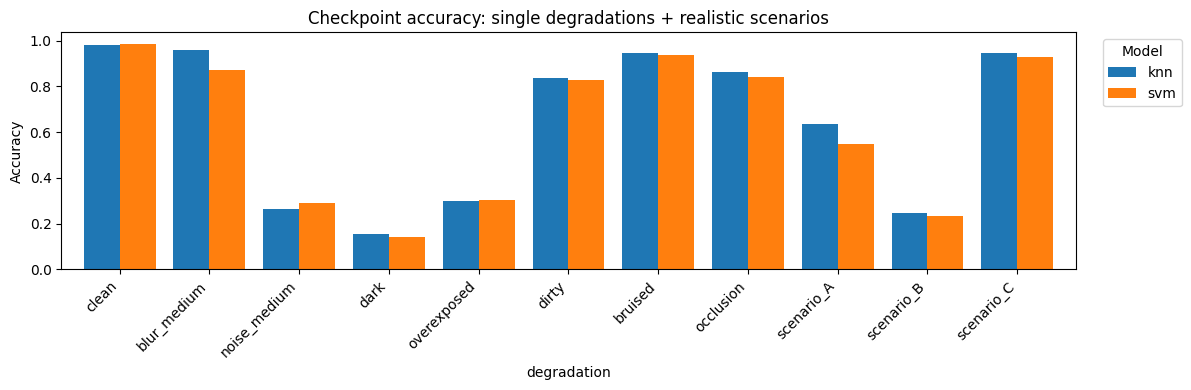

In [ ]:
import matplotlib.pyplot as plt

plot_df = pivot_all.copy()
fig, ax = plt.subplots(figsize=(12, 4))
plot_df.plot(kind="bar", ax=ax, width=0.8)

ax.set_ylabel("Accuracy")
ax.set_title("Checkpoint accuracy: single degradations + realistic scenarios")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Visualization: Accuracy comparison (bar chart)
Grouped bar chart showing accuracy across all test conditions (single degradations + scenarios) for each model. Reveals which test types are hardest and which models are most robust.